# Weighted OLS via gradient descent with MRJob on Hadoop

weight each example as: 

$$weight(x)= abs(1/x)$$


### Generate data

In [46]:
 %matplotlib inline
import numpy as np
import pylab 
size = 1e+6
x = np.random.uniform(-4, 4, size)
y = x * 1.0 - 4 + np.random.normal(0,0.5,size)
data = zip(y,x)
np.savetxt('LinearReg1Mdata.csv',data,delimiter = ",")



/home/cloudera/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/cloudera/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


### Sample data

In [47]:
%%writefile MRSample.py

import numpy as np
from mrjob.job import MRJob
from mrjob.protocol import RawValueProtocol


class MRSample(MRJob):
    
    # output only the sampled values without a key
    OUTPUT_PROTOCOL = RawValueProtocol
    
    # add a sampling probability switch '--p'
    def configure_options(self):
        super(MRSample, self).configure_options()
        self.add_passthrough_option('--p', type = 'float', default = 0.01)
        
    
    def mapper(self, _, line):
        if np.random.uniform(0,1,1) <= self.options.p:
            yield None,line
    

if __name__ == "__main__":
    MRSample.run()

Overwriting MRSample.py


In [48]:
!python MRSample.py LinearReg1Mdata.csv --p 0.01 -r local > 'LinearRegression_1percent.txt'

No configs found; falling back on auto-configuration
Creating temp directory /tmp/MRSample.root.20170303.134625.240507
Running step 1 of 1...
Streaming final output from /tmp/MRSample.root.20170303.134625.240507/output...
Removing temp directory /tmp/MRSample.root.20170303.134625.240507...


In [49]:
!wc -l 'LinearRegression_1percent.txt'

10064 LinearRegression_1percent.txt


In [84]:
%%writefile MrJobBatchGDUpdate_WeightedLinearRegression.py
from mrjob.job import MRJob
import numpy as np

# This MrJob calculates the gradient of the entire training set 
#     Mapper: calculate partial gradient for each example  
#     
class MrJobBatchGDUpdate_WeightedLinearRegression(MRJob):
    # run before the mapper processes any input
    def read_weightsfile(self):
        # Read weights file
        with open('weights.txt', 'r') as f:
            self.weights = [float(v) for v in f.readline().split(',')]
        # Initialze gradient for this iteration
        self.partial_Gradient = [0]*len(self.weights)
        self.partial_count = 0
    
    # Calculate partial gradient for each example 
    def partial_gradient(self, _, line): 
        D = (map(float,line.split(',')))
        # y_hat is the predicted value given current weights
        y_hat = self.weights[0]+self.weights[1]*D[1]
        # calculate weights for the weighted regression (not to be confused with coefficients)
        w = np.abs(1.0/D[1])
        # Update parial gradient vector with gradient form current example
        self.partial_Gradient =  [self.partial_Gradient[0]+ w*(D[0]-y_hat), self.partial_Gradient[1]+w*(D[0]-y_hat)*D[1]]
        self.partial_count = self.partial_count + 1
        #yield None, (D[0]-y_hat,(D[0]-y_hat)*D[1],1)
    
    # Finally emit in-memory partial gradient and partial count
    def partial_gradient_emit(self):
        yield None, (self.partial_Gradient,self.partial_count)
        
    # Accumulate partial gradient from mapper and emit total gradient 
    # Output: key = None, Value = gradient vector
    def gradient_accumulater(self, _, partial_Gradient_Record): 
        total_gradient = [0]*2
        total_count = 0
        for partial_Gradient,partial_count in partial_Gradient_Record:
            total_count = total_count + partial_count
            total_gradient[0] = total_gradient[0] + partial_Gradient[0]
            total_gradient[1] = total_gradient[1] + partial_Gradient[1]
        yield None, [v/total_count for v in total_gradient]
    
    def steps(self):
        return [self.mr(mapper_init=self.read_weightsfile,
                       mapper=self.partial_gradient,
                       mapper_final=self.partial_gradient_emit,
                       reducer=self.gradient_accumulater)] 
    
if __name__ == '__main__':
    MrJobBatchGDUpdate_WeightedLinearRegression.run()

Overwriting MrJobBatchGDUpdate_WeightedLinearRegression.py


### Driver

In [86]:
from numpy import random,array
from MrJobBatchGDUpdate_WeightedLinearRegression import MrJobBatchGDUpdate_WeightedLinearRegression

learning_rate = 0.05
stop_criteria = 0.000005

# Generate random values as inital weights
weights = array([random.uniform(-3,3),random.uniform(-3,3)])
# Write the weights to the files
with open('weights.txt', 'w+') as f:
    f.writelines(','.join(str(j) for j in weights))

# create a mrjob instance for batch gradient descent update over all data
mr_job = MrJobBatchGDUpdate_WeightedLinearRegression(args=['LinearReg1Mdata.csv','--file=weights.txt'])
# Update centroids iteratively

i = 0
while(1):
    print "iteration ="+str(i)+"  weights =",weights
    # Save weights from previous iteration
    weights_old = weights
    with mr_job.make_runner() as runner: 
        runner.run()
        # stream_output: get access of the output 
        for line in runner.stream_output():
            # value is the gradient value
            key,value =  mr_job.parse_output_line(line)
            # Update weights
            weights = weights + learning_rate*array(value)
    i = i + 1
    # Write the updated weights to file 
    with open('weights.txt', 'w+') as f:
        f.writelines(','.join(str(j) for j in weights))
    # Stop if weights get converged
    if(sum((weights_old-weights)**2)<stop_criteria):
        break
        
print "Final weights\n"
print weights

iteration =0  weights = [-2.65958651  1.19283761]
iteration =1  weights = [-2.72661642  1.17347585]
iteration =2  weights = [-2.79029503  1.15605474]
iteration =3  weights = [-2.85078988  1.14037992]
iteration =4  weights = [-2.90826016  1.12627648]
iteration =5  weights = [-2.96285706  1.11358704]
iteration =6  weights = [-3.01472425  1.10216996]
iteration =7  weights = [-3.0639982   1.09189777]
iteration =8  weights = [-3.11080855  1.08265579]
iteration =9  weights = [-3.15527848  1.07434081]
iteration =10  weights = [-3.19752501  1.06685996]
iteration =11  weights = [-3.23765928  1.06012965]
iteration =12  weights = [-3.2757869   1.05407468]
iteration =13  weights = [-3.31200821  1.04862738]
iteration =14  weights = [-3.34641851  1.04372685]
iteration =15  weights = [-3.37910834  1.03931828]
iteration =16  weights = [-3.41016373  1.03535238]
iteration =17  weights = [-3.43966639  1.03178475]
iteration =18  weights = [-3.46769395  1.02857548]
iteration =19  weights = [-3.49432017  1.

### Create plot

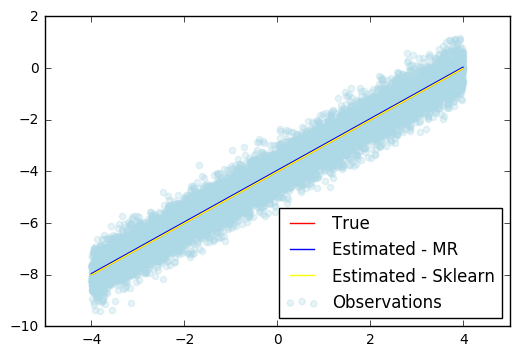

In [120]:
from sklearn.linear_model import LinearRegression

# read in simulating data
YX = np.genfromtxt('LinearRegression_1percent.txt',delimiter=',',dtype=None)
y,x = zip(*YX)


# Fit Sklearn linear regression
LR = LinearRegression()
x= np.array(x).reshape(-1,1)
LR.fit(x,y)


# generate evaluation points for the x axis
xs = np.arange(-4, 4, 0.01)

# function to evaluate
def get_line(m,x,b):
    return m*x+b

# add plot
plt.scatter(x, y,color='lightblue',alpha=0.3,label='Observations')
plt.plot(xs,get_line(1,xs,-4),color='red',label='True')
plt.plot(xs,get_line(1.00009468,xs,-3.9570916),label='Estimated - MR')
plt.plot(xs,get_line(LR.coef_,xs,LR.intercept_),label = 'Estimated - Sklearn',color='yellow')
plt.legend(loc="lower right")